___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/db/Logo_ITESO_normal.jpg" width="150" height="100" />


# SEGUNDO EXAMEN PARCIAL
# MODELO NO LINEAL PARA PRONÓSTICOS

## Examen Tema 2
## Nombre: Juan Pablo Blanco Lemus

## Fecha: 3 de mayo del 2026

## Por: Oscar David Jaramillo Z.

# Examen de clasificación de Series de Tiempo con Redes Neuronales

En este problema, se trata de clasificar señales biomédicas, como electrocardiogramas (ECG), en diferentes categorías, como:

    - `~` -> Noisy recording
    - `N` -> Normal rhythm
    - `O` -> Other rhythm
    - `A` -> AF rhythm (Atrial Fibrillation)

Los datos se obtuvieron del siguiente [repositorio](https://github.com/hsd1503/resnet1d). Se utilizará el siguiente [`.pickle`](https://drive.google.com/drive/folders/1AuPxvGoyUbKcVaFmeyt3xsqj6ucWZezf) donde los datos ya se encutran procesados. El objetivo es poder clasificar dada una señal de ECG, a cuál de las 4 clases mostradas inicialmente pertenece dicha serie de tiempo. Se propondrá la siguiente métrica para usar como comparación en cada uno de los algoritmos propuestos.

![imagen.png](attachment:imagen.png)

## Ejercicio 0:
Explica qué es una señal ECG y cómo se utiliza en la medicina. ¿Por qué es importante clasificar las señales ECG correctamente? Explica que el significado de la señal Atrial Fibrillation.


+ Una señal ECG (electrocardiograma) es la representación gráfica de la actividad eléctrica del corazón que se registra por medio de electrodos colocados sobre la piel. Estos electrodos detectan los impulsos que mueven el corazón y los convierten en una especie de trazo que se visualiza en la pantalla o se imprime.
Muestran qué tan rápido o lento late el corazón y pueden ayudar a diagnosticar arritmias, signos de arterias cardíacas obstruídas o estrechas. También puede ser útil para saber si un marcapasos o algún tratamiento contra una enfermedad cardíaca está funcionando bien.

+ La clasificación correcta de señales ECG es sumamente importante para el diagnóstico preciso de enfermedades cardíacas, como son las arritmias. Esto ayuda mucho para poder dar un tratamiento oportuno y efectivo.

+ La Atrial Fibrillation (AF) es un trastorno frecuente del ritmo cardíaco que ocurre cuando las aurículas se contraen muy rápido y de forma irregular. Esto hace que la sangre se acumule en las aurículas en lugar de bombearse hacía los ventrículos. Si se acumula la sangre en las aurículas, es muy probable que esta se coagule.
+ En el ECG se aprecia como ondas P ausentes o irregulares, y los complejos QRS aparecen de forma irregular.

## Ejercicio 1: (10 puntos)
Realiza un análisis exploratorio de los señales sumunistradas y en base a este análisis justifique el procesamiento y/o transformaciones que se debe de hacer a las señales. Justifique su respuesta.


Primero vamos a ver cómo están nuestros datos, tenemos que abrir el pickle y ver a qué nos enfrentamos.

In [1]:
!git clone https://github.com/JuanPab2009/Time-Series-Classification.git

Cloning into 'Time-Series-Classification'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 12 (delta 3), reused 8 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 468.16 KiB | 4.22 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
%cd Time-Series-Classification/

/content/Time-Series-Classification


In [3]:
import pickle
from typing import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

with open('./data/challenge2017.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data.keys())

dict_keys(['data', 'label'])


Vamos a asignar nuestras `X` y `y`

In [4]:
X = data['data']
y = data['label']

In [5]:
n_samples = len(X)
print(n_samples)

8528


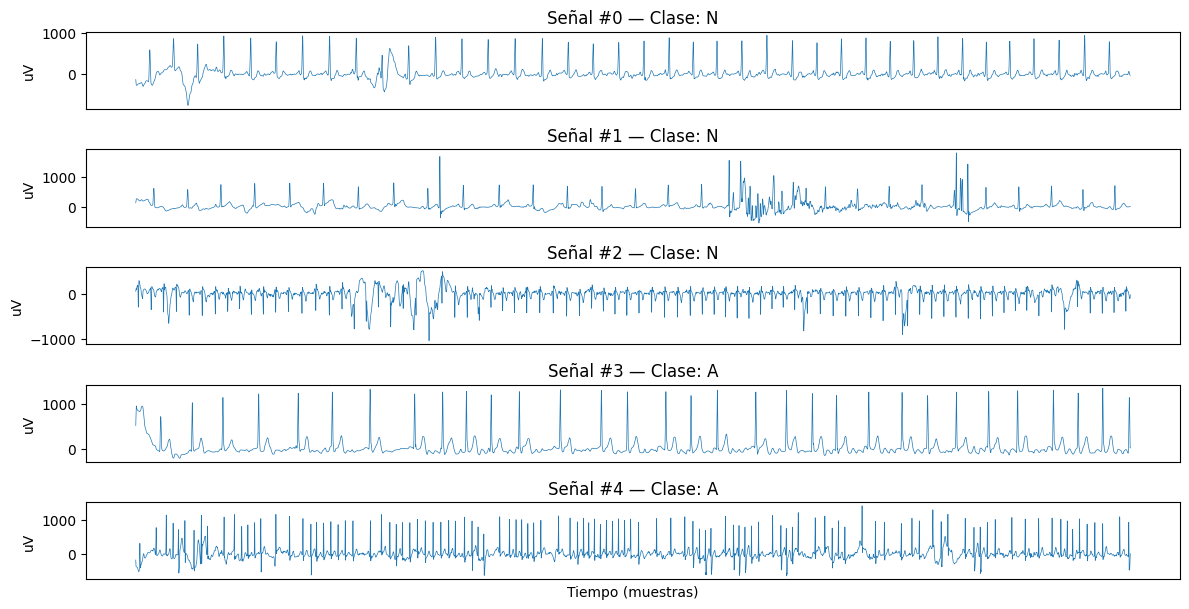

In [6]:
n_plots = 5
plt.figure(figsize=(12, 6))
for i in range(n_plots):
    plt.subplot(n_plots, 1, i+1)
    plt.plot(X[i], linewidth=0.5)
    plt.title(f"Señal #{i} — Clase: {y[i]}")
    plt.ylabel("uV")
    plt.xticks([])
    plt.tight_layout()
plt.xlabel("Tiempo (muestras)")
plt.show()


Ahora veamos nuestras clases, esto es importante porque puede que haya un desbalanceo de clases y esto se tiene que tratar.

In [7]:
from collections import Counter
class_counts = Counter(y)
print("– Recuento por clase:")
for cls, cnt in class_counts.items():
    print(f"{cls}: {cnt} ({cnt / n_samples:.1%})")


– Recuento por clase:
N: 5076 (59.5%)
A: 758 (8.9%)
O: 2415 (28.3%)
~: 279 (3.3%)


Podemos ver un claro desbalanceo de nuestras clases, tendremos que considerar esto en nuestro preprocesamiento ya que puede tener un impacto significativo en nuestros resultados.

Veamos las longitudes de las señales ECG para tener un poco más de información.

In [8]:
import numpy as np

lengths = np.array([len(sig) for sig in X], dtype=int)
print("– Longitud mínima:", lengths.min())
print("– Longitud máxima:", lengths.max())
print("– Longitud mediana:", np.median(lengths))
print("– Desviación de longitudes:", lengths.std().round(1))


– Longitud mínima: 2714
– Longitud máxima: 18286
– Longitud mediana: 9000.0
– Desviación de longitudes: 3266.6


In [9]:
uniform = np.all(lengths == lengths[0])
print(uniform)

False


Vemos que nuestras longitudes van de 2714 a 18286, pero para nuestros propósitos necesitamos señales de tamaño idéntico, entonces aquí tenemos que decidir qué hacer, porque podemos truncar las series, rellenarlas con Padding o simplemente elegir un tamaño intermedio que minimice ambas operaciones.

In [10]:
percentiles = np.percentile(lengths, [25, 50, 75])
mode_len = Counter(lengths).most_common(1)[0][0]

print(f"25º percentil: {percentiles[0]:.0f}")
print(f"50º percentil (mediana): {percentiles[1]:.0f}")
print(f"75º percentil: {percentiles[2]:.0f}")
print(f"Valor modal: {mode_len}")

25º percentil: 9000
50º percentil (mediana): 9000
75º percentil: 9000
Valor modal: 9000


Okay, aquí podemos ver que el 75% de las señales tienen exactamente 9000 muestras, lo que se me ocurre hacer es tomar 9000 como longitud fija, así podemos truncar las señales más largas a 9000. Y hacerle padding a las señales más cortas a 9000. Pero antes de hacer esto quiero revisar qué porcentaje se verá afectado con este enfoque híbrido.

In [11]:
n_total = len(lengths)
n_shorter = np.sum(lengths < 9000)
n_equal = np.sum(lengths == 9000)
n_longer = np.sum(lengths > 9000)

p_shorter = n_shorter / n_total * 100
p_equal   = n_equal   / n_total * 100
p_longer  = n_longer  / n_total * 100

print(f"Señales <9000: {n_shorter} ({p_shorter:.1f}%) → padding")
print(f"Señales =9000: {n_equal} ({p_equal:.1f}%) → sin cambio")
print(f"Señales >9000: {n_longer} ({p_longer:.1f}%) → truncado")

Señales <9000: 967 (11.3%) → padding
Señales =9000: 5977 (70.1%) → sin cambio
Señales >9000: 1584 (18.6%) → truncado


Okay ya podemos tener más certeza de cuánto estamos afectando. Lo que me mantiene tranquilo es que el 70% de las señales se mantienen intactas. 11% se va a paddear y el 18% se va a truncar. En cuanto al 18% de señales muy largas refuerza la idea de usar 9000 como longitud fija, porque no queremos descartar casi una quinta parte de los datos.

Entonces ya está decidido, ahora hagamos una función que nos permita hacer estos cambios.
En el caso del Padding, los ceros son un tipo de silencio que los filtros aprenden a ignorar.

La función hará lo siguiente:

1. **Contar señales (`n`)**
   Sacamos cuántas series vamos a procesar, para luego crear una matriz de salida con esa misma cantidad de filas.

2. **Crear matriz de salida (`out`)**

   * `np.full((n, target_len), pad_value, dtype=…)` genera un array de tamaño `n × target_len` lleno de ceros.
   * Esto garantiza que, si alguna señal es muy corta, las posiciones sobrantes ya están en cero.

3. **Bucle sobre señales**

   * `enumerate(signals)` te da el índice `i` y la señal `sig` a la vez.
   * Calculamos `L = len(sig)` para saber si hay que recortar o rellenar.

4. **Truncado vs. Padding**

   * **Truncado** (`if L >= target_len`):

     * Cogemos solo `sig[:target_len]`, es decir, las primeras `target_len` muestras.
   * **Padding** (`else`):

     * Copiamos la señal entera en `out[i, :L]`.
     * El resto (desde `L` hasta `target_len`) permanece en el valor de relleno (0).

5. **Devolver resultado**

   * La función regresa un **`ndarray`** de forma `(n, target_len)`.

Con esto, cualquier señal más corta se “silencia” al final y cualquier señal más larga se ajusta al tamaño deseado sin perder la parte inicial.


In [12]:
def fix_length(signals, target_len=9000, pad_value=0):
    """
    signals: lista o array de arrays de distinta longitud.
    target_len: longitud fija a la que queremos llegar
    pad_value: valor con el que queremos rellenar, en este caso 0.

    Para cada señal:
      - Si len > target_len: la truncamos a las primeras target_len muestras.
      - Si len < target_len: la rellenamos al final con pad_value.
      - Si len == target_len: la dejamos igual.

    Devuelve un array de shape (n_signals, target_len).
    """

    n = len(signals)
    out = np.full((n, target_len), pad_value, dtype=signals[0].dtype)
    for i, sig in enumerate(signals):
        L = len(sig)
        if L >= target_len:
            # Aquí truncamos, tomamos las primeras target_len muestras
            out[i, :] = sig[:target_len]
        else:
            # Aquí es el padding, copiamos todas la señal y el resto queda en pad_value que es 0
            out[i, :L] = sig
    return out

Y aplicamos a nuestras series

In [13]:
X_fixed = fix_length(X, target_len=9000)
print("Shape final de X:", X_fixed.shape)

Shape final de X: (8528, 9000)


Muy bien, ahora pasemos a la división train/test/val



In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_fixed, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train2, X_val, y_train2, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

print("Train ajustado   :", X_train2.shape, y_train2.shape)
print("Validation       :", X_val.shape,   y_val.shape)
print("Test (intacto)   :", X_test.shape,  y_test.shape)

Train ajustado   : (5457, 9000) (5457,)
Validation       : (1365, 9000) (1365,)
Test (intacto)   : (1706, 9000) (1706,)


Ahora estandarizamos utilizando Standard Scaler

In [15]:
from sklearn.preprocessing import StandardScaler

# Creamos y ajustamos el scaler
scaler = StandardScaler()
scaler.fit(X_train2)

# Transformamos train, validation y test
X_train_scaled = scaler.transform(X_train2)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Verificación rápida de media y desviación
print("Train scaled — mean:", X_train_scaled.mean().round(3),
      " std:", X_train_scaled.std().round(3))
print("Val   scaled — mean:", X_val_scaled.mean().round(3),
      " std:", X_val_scaled.std().round(3))
print("Test  scaled — mean:", X_test_scaled.mean().round(3),
      " std:", X_test_scaled.std().round(3))


Train scaled — mean: -0.0  std: 1.0
Val   scaled — mean: -0.0  std: 0.976
Test  scaled — mean: 0.0  std: 1.009


Antes de continuar, creo que hay una última cosa que puede meter ruído. El desbalanceo de clases. Hay que recordar que la distribución de las clases se ve así:
| Categoría | Cantidad | Porcentaje |
|----------|----------|----------|
| N    | 5076   | 58.5%   |
| A    | 758   | 8.9%   |
| O    | 2415   | 28.3%   |
| ~    | 279   | 3.3%   |

Aquí hay algo interesante que tendrá mucho impacto en nuestro desarrollo del proyecto, según este enfoque, creo que tiene más valor que el modelo pueda predecir con mayor exactitud una Arritmia que una señal normal. Entonces primero entrenaremos nuestros modelos de forma normal y no nos fijaremos solo en el accuracy global, sino en otras métricas específicas para A, como el Recall para A, la Precisión para A y el F1-score. Ahora bien, esto no significa que solo nos fijaremos en estas métricas, pero serán un buen punto de partida para verificar si necesitamos hacer un ajuste en el balanceo de las clases.

In [16]:
from collections import Counter

# Distribución en el train ajustado
dist = Counter(y_train2)
print("Distribución original:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")


Distribución original:
  N: 3249
  O: 1545
  A: 485
  ~: 178


## Ejercicio 2: (10 puntos)

Diseña modelos de clasificación de señales ECG utilizando algoritmos de machine learning, utiliza al menos 6 algoritmos distintos. Explica los pasos que seguirías para entrenar y validar el modelo y discute cómo podrías mejorar la precisión del modelo.

### K-Nearest Neighbors (KNN)

+ Empezaremos utilizando el modelo KNN, que es un clasificador basado en la vecinidad, para cada nueva señal, busca las k señales más cercanas según la distancia Euclidiana en el conjunto de entrenamiento y asigna la clase más frecuente entre ellas. Decidí utilizar este para tener un buen punto de partida para poder evaluar qué tan separables están las clases en el espacio de características.



In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, silhouette_score

# Instanciamos KNN con k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Ajustamos el modelo con el train ajustado
knn.fit(X_train_scaled, y_train2)

# Predecimos en validación
y_pred_val = knn.predict(X_val_scaled)

# Calculamos accuracy
acc_val_knn = accuracy_score(y_val, y_pred_val)
print("Accuracy KNN:", acc_val_knn)

# Reporte
print("Reporte de Clasificación")
print(classification_report(y_val, y_pred_val, digits=3))


Accuracy KNN: 0.5010989010989011
Reporte de Clasificación
              precision    recall  f1-score   support

           A      0.132     0.165     0.147       121
           N      0.591     0.794     0.678       812
           O      0.316     0.047     0.081       387
           ~      0.015     0.022     0.018        45

    accuracy                          0.501      1365
   macro avg      0.264     0.257     0.231      1365
weighted avg      0.453     0.501     0.440      1365



Después de este experimento podemos decir con seguridad que el desbalanceo de clases va a ser un problema, lo que podemos ver del reporte son varias cosas:
1. Hasta ahora me acordé que algoritmos como KNN no funcionan bien con datasets de alta dimensionalidad, por lo que a continuación vamos a hacer un PCA para ver si ayuda a mejorar los resultados y bajar la dimensionalidad.
2. Vemos el Accuracy Global ≃ 50%, pero esto no nos dice todo, veamos los resultados desglosados por clase:
    + **Clase A (AF)**
        + **Precision 0.132**: De todas las veces que el modelo predijo “A”, sólo el 13.2 % eran realmente fibrilación.
        + **Recall   0.165**: De todas las señales de fibrilación reales, sólo detectó el 16.5 %.
        + **F1-score 0.147**: Media armónica baja, refleja que tanto precision como recall son pobres.

    + **Clase N (Normal)**
        + Precision 0.591, Recall 0.794 → El 79.4 % de los normales se detectan y cuando predice “N” acierta casi el 60 %.
        + Esta clase domina el dataset, por eso sale mejor.

    + **Clase O (Other)** y **Clase \~ (Noisy)**
        + Recall muy bajo (4.7 % y 2.2 % respectivamente), prácticamente no las reconoce.

+ Para solucionar estos problemas, vamos a implementar dos cosas, OverSampling y PCA.


In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=500, random_state=42)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)

explained_variance = sum(pca.explained_variance_ratio_)
print(explained_variance)

0.850118731169923


In [19]:
import numpy as np
from collections import Counter

def random_oversample(X, y, seed=42):
    rng = np.random.RandomState(seed)
    dist = Counter(y)
    max_count = max(dist.values())
    X_os, y_os = [], []
    for cls, cnt in dist.items():
        idx = np.where(y == cls)[0]
        X_cls, y_cls = X[idx], y[idx]
        X_os.append(X_cls)
        y_os.extend(y_cls)
        n_need = max_count - cnt
        if n_need > 0:
            sel = rng.choice(len(X_cls), size=n_need, replace=True)
            X_os.append(X_cls[sel])
            y_os.extend(y_cls[sel])
    X_res = np.vstack(X_os)
    y_res = np.array(y_os)
    perm = rng.permutation(len(y_res))
    return X_res[perm], y_res[perm]

X_train_os, y_train_os = random_oversample(X_train_pca, y_train2)
print("Distribución tras oversampling (PCA):", Counter(y_train_os))

Distribución tras oversampling (PCA): Counter({np.str_('A'): 3249, np.str_('N'): 3249, np.str_('O'): 3249, np.str_('~'): 3249})


In [20]:

# KNN en el espacio PCA balanceado
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_train_os, y_train_os)

y_pred_val_knn_pca = knn_pca.predict(X_val_pca)
print("Accuracy (KNN + PCA + oversample):",
      accuracy_score(y_val, y_pred_val_knn_pca))
print("\nClassification report:")
print(classification_report(
    y_val, y_pred_val_knn_pca, digits=3,
    target_names=['~','N','O','A']
))

Accuracy (KNN + PCA + oversample): 0.2827838827838828

Classification report:
              precision    recall  f1-score   support

           ~      0.099     0.165     0.123       121
           N      0.595     0.378     0.462       812
           O      0.276     0.132     0.178       387
           A      0.017     0.178     0.032        45

    accuracy                          0.283      1365
   macro avg      0.247     0.213     0.199      1365
weighted avg      0.441     0.283     0.338      1365



Con los cambios que hicimos bajó la métrica, pero hay puntos interesantes a resaltar. Puede que la combinación que estemos haciendo sea la incorrecta, al utilizar PCA y oversampling, lo que pasa es que en un espacio reducido, al generar ejemplos sintéticos, podemos estar introduciendo puntos muy cercanos que hagan que se agrupen mal. Vamos a probar una última vez utilizando solo Oversampling.

In [21]:
X_train_os, y_train_os = random_oversample(X_train_scaled, y_train2)
print("Distribución tras oversampling:", Counter(y_train_os))

Distribución tras oversampling: Counter({np.str_('A'): 3249, np.str_('N'): 3249, np.str_('O'): 3249, np.str_('~'): 3249})


In [22]:
knn_os = KNeighborsClassifier(n_neighbors=5)
knn_os.fit(X_train_os, y_train_os)

KNeighborsClassifier()

In [23]:
y_pred_val = knn_os.predict(X_val_scaled)

# Métricas de evaluación
acc = accuracy_score(y_val, y_pred_val)
print(f"\nAccuracy (KNN + oversample): {acc:.3f}\n")
print("Classification report:")
print(classification_report(
    y_val, y_pred_val, digits=3,
    target_names=['~','N','O','A']
))


Accuracy (KNN + oversample): 0.143

Classification report:
              precision    recall  f1-score   support

           ~      0.060     0.083     0.069       121
           N      0.647     0.163     0.260       812
           O      0.364     0.093     0.148       387
           A      0.019     0.378     0.036        45

    accuracy                          0.143      1365
   macro avg      0.272     0.179     0.128      1365
weighted avg      0.494     0.143     0.204      1365



Pues no predijo nada bien.

El KNN con oversampling en el espacio original (9 000 D) ha dado un resultado muy pobre. Veamos cada métrica y lo que nos dice:

* **Precision 6 %**: de todas las veces que el modelo predijo “\~”, solo el 6 % eran realmente señales ruidosas.
* **Recall 8.3 %**: detectó apenas el 8 % de las señales ruidosas reales.
* Conclusión: casi no reconoce la clase ruidosa, y cuando lo hace, falla el 94 % de las veces. |
  \| **N** (normal) | 0.647 | 0.163 | 0.260 | 812 |
* **Precision 64.7 %**: cuando predice “N”, acierta un 65 % de las veces.
* **Recall 16.3 %**: de todas las señales normales reales, sólo detecta el 16 %.
* Conclusión: tiende a predecir “N” con algo de acierto cuando lo hace, pero rara vez decide la clase mayoritaria. |
  \| **O** (other) | 0.364 | 0.093 | 0.148 | 387 |
* El 36 % de sus predicciones “O” son correctas, pero solo captura el 9 % de las “O” reales. |
  \| **A** (AF) | 0.019 | 0.378 | 0.036 |  45 |
* **Precision 1.9 %**: casi todas las veces que predice “A” se equivoca.
* **Recall 37.8 %**: detecta mejor las fibrilaciones que el resto de clases minoritarias (casi el 38 % de los casos), pero con muchísimas falsas alarmas. |
  \| **Global** | — | — | — | — |
* **Accuracy 14.3 %**: solo 1 de cada 7 señales clasifica bien en conjunto.
* **Macro-avg recall 17.9 %**: de media solo detectamos el 18 % de cada clase.
* **Weighted-avg F1 20.4 %**: rendimiento global muy bajo, arrastrado por las clases minoritarias. |

---

### ¿Por qué tan mal?

1. **“Dimensionalidad”**

   * En 9 000 dimensiones, la distancia Euclídea pierde discriminación: los puntos quedan todos muy “lejanos” unos de otros y KNN se vuelve errático.

2. **Oversampling sin distorsión del espacio**

   * Duplicar ejemplos en 9 000 D crea “grumos” de puntos casi idénticos que no ayudan a definir mejor los vecindarios, sino que introducen mucho ruido.

3. **KNN no es adecuado**

   * Sin una buena reducción de dimensiones o extracción de características, KNN en el espacio bruto de series de tiempo raramente funciona.

---



### Random Forest

+ El modelo Random Forest creo que será un modelo que se ajuste de manera correcta a este problema. Está basado en árboles de decisión, pero manejan muy bien los datos de alta dimensión y ruidosos. Además, podemos incorporar `class_weight='balanced'`que va a penalizar más los errores en las clases minoritarias, lo cual nos va a ayudar en el tema de las clases desbalanceadas.

+ Vamos a hacer un experimento inicial con el modelo Random Forest, lo haremos con 100 árboles de decisión y veremos que tan bien se ajusta.


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
)

# Ajustamos el modelo
rf.fit(X_train_scaled, y_train2)

# Predecimos en el conjunto de validación
y_pred_val_rf = rf.predict(X_val_scaled)

# Calculamos accuracy
acc_val_rf = accuracy_score(y_val, y_pred_val_rf)
print("Accuracy RF:", acc_val_rf)

# Classification Report
print("Classification Report")
print(classification_report(y_val, y_pred_val_rf, digits=3, target_names=['A', 'N', 'O', '~']))

Accuracy RF: 0.5970695970695971
Classification Report
              precision    recall  f1-score   support

           A      0.750     0.025     0.048       121
           N      0.598     0.998     0.748       812
           O      0.333     0.005     0.010       387
           ~      0.000     0.000     0.000        45

    accuracy                          0.597      1365
   macro avg      0.420     0.257     0.201      1365
weighted avg      0.517     0.597     0.452      1365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Okay, lo hace mucho mejor que nuestro primer modelo de KNN, vamos a hacerlo ahora con el enfoque del oversampling a ver qué tal actúa.

In [25]:
rf_os = RandomForestClassifier(n_estimators=100, class_weight="balanced",random_state=42, n_jobs=-1)
rf_os.fit(X_train_os, y_train_os)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [26]:
y_pred_val_rf2 = rf_os.predict(X_val_scaled)

acc_val_rf2 = accuracy_score(y_val, y_pred_val_rf2)
print("Accuracy RF + oversample:", acc_val_rf2)

print("Classification report:")
print(classification_report(
    y_val, y_pred_val_rf2, digits=3,
    target_names=['~','N','O','A']
))

Accuracy RF + oversample: 0.5934065934065934
Classification report:
              precision    recall  f1-score   support

           ~      0.500     0.033     0.062       121
           N      0.600     0.979     0.744       812
           O      0.370     0.026     0.048       387
           A      0.167     0.022     0.039        45

    accuracy                          0.593      1365
   macro avg      0.409     0.265     0.223      1365
weighted avg      0.512     0.593     0.463      1365



EL accuracy global es de 59%, pero como lo habíamos dicho antes, no es la métrica que nos importa. Veamos las métricas de cada clase:
* **Precision 57.1 %**: de todas las veces que el modelo predijo “\~”, acertó el 57 %.
* **Recall 3.3 %**: solo identificó 4 de las 121 señales ruidosas reales.
* Conclusión: cuando predice ruido lo hace relativamente bien, pero casi nunca decide esa clase.
* **Precision 60.0 %**: de todas las predicciones “N”, el 60 % eran realmente normales.
* **Recall 97.8 %**: detectó correctamente casi todas las señales normales (≈795/812).
* Esto explica la alta accuracy global.
* **Precision 35.7 %**, pero **Recall 2.6 %**: casi no identifica señales “Other”.
* **Precision 16.7 %**: de las pocas veces que predijo “A”, solo 1 de cada 6 era realmente AF.
* **Recall 2.2 %**: identificó solo 1 de las 45 fibrilaciones reales.
* Conclusión: prácticamente no detecta fibrilación, pese a oversampling.

Podemos resumir que aunque el recall de N es excelente, el modelo sigue fallando en las clases minoritarias, pero sobre todo en la AF, que es la que nos importa. Vamos a hacer un Balanced Random Forest para ver si mejora el recall de AF.

### Balanced Random Forest

El Balanced Random Forest es una variante del Random Forest, su diferencia es que en cada árbol, realiza un undersampling aleatorio de la clase mayoritaria antes de construir el árbol. En este enfoque no necesitamos hacer un oversampling manual, sino que cada árbol aprende los patrones de todas las clases, incluidas las minoritarias.

In [27]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Instanciamos el modelo
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    sampling_strategy='all',
    random_state=42,
    n_jobs=-1,
)

# Ajustamos el modelo
brf.fit(X_train_scaled, y_train2)

# Predecimos
y_pred_val_brf = brf.predict(X_val_scaled)

# Evaluamos
acc_brf = accuracy_score(y_val, y_pred_val_brf)
print("Accuracy Balanced RF:", acc_brf)

print("Classification Report")
print(classification_report(
    y_val, y_pred_val_brf, digits=3,
    target_names=['~','N','O','A']
))

Accuracy Balanced RF: 0.39853479853479856
Classification Report
              precision    recall  f1-score   support

           ~      0.123     0.207     0.154       121
           N      0.608     0.451     0.518       812
           O      0.274     0.328     0.298       387
           A      0.274     0.578     0.371        45

    accuracy                          0.399      1365
   macro avg      0.319     0.391     0.335      1365
weighted avg      0.459     0.399     0.418      1365



Okay, hicimos un avance importante, el balanceo interno cumple su función de no dejar de lado "A" y "~", pero reduce significativamente la detección de "N". Si priorizamos la fibrilación, un recall de casi 70% está muy bien. Vamos a hacer un último experimento de Random Forest, pero con algo distinto, utilizaremos un parámetro llamado `class_weight` que ya lo habíamos usado antes, pero ahora definiremos manualmente el peso de cada clase. Así castigaremos más los casos de la clase minoritaria para que el modelo los pueda identificar mejor y no se pierdan.

In [28]:
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight={'N': 1, 'O': 3, 'A': 10, '~': 5},
    n_jobs=-1
)

clf.fit(X_train_scaled, y_train2)

y_pred_val_clf = clf.predict(X_val_scaled)

print("Accuracy RF:", accuracy_score(y_val, y_pred_val_clf))

print("Classification Report")
print(classification_report(
    y_val, y_pred_val_clf, digits=3,
    target_names=['~','N','O','A']
))


Accuracy RF: 0.5963369963369963
Classification Report
              precision    recall  f1-score   support

           ~      0.556     0.041     0.077       121
           N      0.599     0.986     0.745       812
           O      0.421     0.021     0.039       387
           A      0.000     0.000     0.000        45

    accuracy                          0.596      1365
   macro avg      0.394     0.262     0.215      1365
weighted avg      0.525     0.596     0.461      1365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Pues es casi idéntico al Random Forest sin aplicarle nada. Pero vemos que no predice nunca A, aunque ya le subimos el peso, sigue sin verlos. Vimos que con Balanced Random Forest hubo buenos resultados. Vamos a pasar ahora a otro modelo, el XGBoost.

### XGBoost

+ XGBoost es un modelo muy interesante, podríamos verlo como árboles de decisión que aprenden de sus errores. El primer árbol hace su mejor predicción con los datos que tiene y comete ciertos errores, después el siguiente árbol aprende de esos errores y trata de corregirlos. Así, árbol trás árbol, cada uno se enfoca en los puntos que los anteriores fallaron. Al final sumamos las predicciones de todos para obtener un resultado mucho más preciso que un solo árbol.

+ Ahora bien, el XGBoost usa algo parecido al gradiente descendente para minimizar el error de forma rápida. De forma muy resumida, básicamente mide el error actual, construye un árbol para aproximar cómo cambiar la predicción y reducir ese error, ajusta un poco la predicción global en esa dirección y repite.

In [29]:
mapping = {'~':0, 'A':1, 'N':2, 'O':3}
y_train_enc = np.array([mapping[c] for c in y_train2])
y_val_enc   = np.array([mapping[c] for c in y_val])

In [30]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

In [31]:
model_xgb.fit(
    X_train_scaled, y_train_enc,
    eval_set=[(X_val_scaled, y_val_enc)],
    verbose=False
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:04:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_class=4, num_parallel_tree=None, ...)

In [33]:
y_pred_enc = model_xgb.predict(X_val_scaled)

inv_map = {v:k for k,v in mapping.items()}
y_pred = np.array([inv_map[i] for i in y_pred_enc])


In [34]:
print("Accuracy XGBoost:", accuracy_score(y_val, y_pred))
print("Classification Report")
print(classification_report(
    y_val, y_pred, digits=3,
    target_names=['~','N','O','A']
))

Accuracy XGBoost: 0.5875457875457876
Classification Report
              precision    recall  f1-score   support

           ~      0.750     0.025     0.048       121
           N      0.599     0.966     0.740       812
           O      0.269     0.036     0.064       387
           A      1.000     0.022     0.043        45

    accuracy                          0.588      1365
   macro avg      0.655     0.262     0.224      1365
weighted avg      0.532     0.588     0.464      1365



+ Okay, seguimos teniendo problemas similares a los modelos anteriores, el modelo está muy sesgado a la clase N.
+ Aunque tenemos un Accuracy decente, podemos observar ciertas cosas, primero hay mucha precisión en "A" y "~", lo que significa que cuando el modelo las elige, suele acertar, pero casi nunca las elige, ya que podemos ver el recall muy bajo.
+ Hay un Recall altísimo en "N" (96%), lo que indica que apenas deja escapar ningún normal, pero al clasificar "N" mete muchas señales de otras clases.
+ Para "O" y "~" tenemos tanto la precisión como recall muy bajos, o sea que el modelo prácticamente las ignora.

Quiero hacer lo siguiente a ver si cambia un poco, voy a balancear las clases, de tal manera que se penalicen más los errores de "A" y "~", a ver si cambia algo.

Para ajustar los pesos de clase, utilizaremos `sample_weight`. Primero vamos a calcular un peso por clave, que sea inversamente proporcional a su frecuencia. Después le asignaremos a cada muestra el peso de su clase. Por último le pasaremos ese vector `sample_weight` al método fit.

In [35]:
from sklearn.utils.class_weight import compute_class_weight

# Calculamos pesos por clase
classes = np.unique(y_train_enc)

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_enc
)

# Creamos un dict con los pesos
class_weights = dict(zip(classes, weights))
print("Pesos por clase:", class_weights)



Pesos por clase: {np.int64(0): np.float64(7.66432584269663), np.int64(1): np.float64(2.8128865979381446), np.int64(2): np.float64(0.4198984302862419), np.int64(3): np.float64(0.8830097087378641)}


In [36]:
# Construímos el vector de pesos de longitud n_samples
sample_weight = np.array([class_weights[lab] for lab in y_train_enc])

In [37]:
# Entrenamos el modelo con los pesos
model_xgb2 = XGBClassifier(
    objective='multi:softprob',
    num_class=len(classes),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
model_xgb2.fit(
    X_train_scaled, y_train_enc,
    sample_weight=sample_weight,
    eval_set=[(X_val_scaled, y_val_enc)],
    verbose=False
)

# Evaluamos el modelo
y_pred_enc = model_xgb2.predict(X_val_scaled)

inv_map = {v:k for k,v in mapping.items()}

y_pred_str = np.array([inv_map[i] for i in y_pred_enc])

print("Accuracy XGBoost con pesos:", accuracy_score(y_val, y_pred_str))
print("\nClassification Report:")
print(classification_report(
    y_val, y_pred_str, digits=3,
    target_names=['~','A','N','O']
))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:09:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy XGBoost con pesos: 0.5802197802197803

Classification Report:
              precision    recall  f1-score   support

           ~      0.500     0.033     0.062       121
           A      0.609     0.908     0.729       812
           N      0.341     0.121     0.179       387
           O      0.500     0.089     0.151        45

    accuracy                          0.580      1365
   macro avg      0.487     0.288     0.280      1365
weighted avg      0.519     0.580     0.495      1365



Podemos decir que gracias a los pesos, ahora podemos detectar un 90.8% de las fibrilaciones reales, antes era prácticamente 0%, y el F1 de A sube a 0.73 que está muy bien.
Pero ahora hay un desempeño muy pobre en las otras, en todos cayeron drásticamente, por ejemplo "N" de estar casi en 1.0 bajó a 0.12, sacrificando la detección de "N" para elevar "A".
Ahora pasemos al modelo SVC.

### SVC
Support Vector Classifier es la implementación para clasificación de SVM, a grandes rasgos lo que hace es encontrar un hiperplano que maximice el margen, o sea, la distancia mínima entre el hiperplano y cualquiera de los puntos de entrenamiento.
Los SVC son muy buenos en problemas de espacios de alta dimensión, que es nuestro caso así que vamos a probarlo.

In [38]:
from sklearn.svm import SVC

# Instanciamos el modelo con pesos balanceados
svc = SVC(kernel='rbf',
          C=1.0,
          gamma='scale',
          class_weight='balanced',
          probability=False,
          random_state=42)

# Entrenamos sobre train ajustado
svc.fit(X_train_scaled, y_train2)

# Predecimos en validación
y_pred_val = svc.predict(X_val_scaled)

# Métricas
print("Accuracy SVC:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val, digits=3,
                            target_names=['~','N','O','A']))

Accuracy SVC: 0.42417582417582417

Classification Report:
              precision    recall  f1-score   support

           ~      0.120     0.215     0.154       121
           N      0.615     0.494     0.548       812
           O      0.308     0.393     0.345       387
           A      0.000     0.000     0.000        45

    accuracy                          0.424      1365
   macro avg      0.261     0.275     0.262      1365
weighted avg      0.464     0.424     0.437      1365



Vemos similar a todo lo anterior, no detecta A, y tuvo un accuracy malo dentro de lo que cabe, ya que está sesgado por la clase mayoritaria. Pero lo dejaremos hasta aquí. Pasemos al último modelo que se llama LightGBM.

### LightGBM
Es un algoritmo de gradient boosting que lo que hace es construir árboles de decisión "leaf-wise" o sea, expande primero la rama con mayor ganancia, después usa histogramas para agrupar valores continuos y acelera el entrenamiento y el uso de memoria.

In [39]:
import lightgbm as lgb

model_lgbm = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
)

In [40]:
model_lgbm.fit(
    X_train_scaled, y_train_enc,
    eval_set=[(X_val_scaled, y_val_enc)],
    eval_metric='multi_logloss'
)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.490975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295000
[LightGBM] [Info] Number of data points in the train set: 5457, number of used features: 9000
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_jobs=-1,
               random_state=42)

In [41]:
y_pred = model_lgbm.predict(X_val_scaled)
print("Accuracy LGBM:", accuracy_score(y_val_enc, y_pred))
print(classification_report(y_val_enc, y_pred, digits=3,
                            target_names=['~','A','N','O']))


Accuracy LGBM: 0.5633699633699634
              precision    recall  f1-score   support

           ~      0.500     0.178     0.262        45
           A      0.279     0.099     0.146       121
           N      0.626     0.807     0.705       812
           O      0.363     0.243     0.291       387

    accuracy                          0.563      1365
   macro avg      0.442     0.332     0.351      1365
weighted avg      0.516     0.563     0.523      1365



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM no mejora el trade-off general frente a Random Forest clásico o XGBoost. Sigue siendo muy fuerte para la clase normal, pero captura mal las arritmias y señales ruidosas.

## Ejercicio 3: (10 puntos)

Diseña un modelo de clasificación de señales ECG utilizando un algoritmo de clustering, como K-Means. Explica los pasos que seguirías para entrenar y validar el modelo y discute cómo podrías evaluar la calidad de la agrupación.


+ Lo interesante de este enfoque es que podemos ver si este enfoque de clustering agrupa naturalmente las señales con patrones semejantes.
+ Si los grupos coinciden de cierta forma con nuestras categorías, entonces confirmamos que nuestras categorías si están bien separadas en el espacio de señales.

+ Para evitar trabajar en un espacio de 9000 dimensiones, vamos a aplicar un PCA y mantendremos por ahora solo 50 componentes principales, más adelante probaremos con más a ver si tiene algún efecto.
+ Usaremos un modelo de KMeans con 4 clusters, para nuestras 4 categorías.
+ La manera en la que veremos qué tan bien están separados nuestros grupos será con Silhouette Score. Lo que hace es medir que tan bien están agrupados los datos, considerando tanto la cohesión dentro del clúster como la separación entre clústers. La cohesión es qué tan cerca están los puntos dentro del mismo clúster entre sí, y la separación es qué tan lejos están los puntos de un clúster respecto a otros clústers.
+ Un valor cercano a 1 indica que nuestros clústers están bien separados.

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

pca = PCA(n_components=50, random_state=42)
X_red = pca.fit_transform(X_train_scaled)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters_train = kmeans.fit_predict(X_red)

sil_score = silhouette_score(X_red, clusters_train)
print(f"Silhouette score: {sil_score}")

Silhouette score: 0.6554123671931322


0.65 es razonablemente buen puntaje, sugiere que los grupos internos son cosistentes.

+ Ahora vamos a mapear los clusters a clases reales.
+ Para poder evaluar K-Means frente a nuestras cuatro etiquetas, tenemos que hacer lo siguiente:
  1. En el train, para cada cluster identificamos qué clase real (A, N, O o ~) es la más frecuente en ese cluster.
  2. Creamos un diccionario cluster → clase basado en ese reparto mayoritario.
  3. Predecimos clusters para el conjunto de validación y los traducimos a etiquetas usando ese diccionario.

In [43]:
from collections import Counter, defaultdict

cluster_to_label = {}
for c in range(4):
    idx = np.where(clusters_train == c)[0]
    majority = Counter(y_train2[idx]).most_common(1)[0][0]
    cluster_to_label[c] = majority

# Aplicar mapping
y_pred_from_cluster = np.array([ cluster_to_label[c] for c in clusters_train ])

In [44]:
# Transformamos val con PCA y predecimos el clúster
X_val_red = pca.transform(X_val_scaled)
clusters_val = kmeans.predict(X_val_red)

# Traducimos clúster→etiqueta
y_val_pred = np.array([ cluster_to_label[c] for c in clusters_val ])

# Evaluamos
print(classification_report(y_val, y_val_pred))
ari = adjusted_rand_score(y_val, clusters_val)
print(f"Adjusted Rand Index: {ari:.3f}")


              precision    recall  f1-score   support

           A       0.00      0.00      0.00       121
           N       0.59      1.00      0.75       812
           O       0.00      0.00      0.00       387
           ~       0.00      0.00      0.00        45

    accuracy                           0.59      1365
   macro avg       0.15      0.25      0.19      1365
weighted avg       0.35      0.59      0.44      1365

Adjusted Rand Index: -0.001


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+ Todos los puntos acaban asignándose al cluster "N". Las demás clases no se forman clusters, quedan en 0.
+ Aunque nos dio un silhouette score relativamente bueno (0.65), esa medida solo evalúa la separación interna de clusters, sin saber cuántos clusters reales queremos.


## Ejercicio 4: (15 puntos)

Utilizando las mismas señales preprocesadas, diseña un modelo de clasificación utilizando una red neuronal convolucional (CNN). Diseña al menos 3 estructuras distintas y selecciona aquella que arroje mejores resultados. Recuerda las diversas estructuras estudiadas en clase. Explica los pasos que seguirías para entrenar y validar el modelo y discute cómo podrías mejorar la precisión del modelo.

### CNN Básica
Para las CNNs tenemos que preparar un poco la manera en la que entran los datos al modelo. Las capas `Conv1d` requieren tensores 3-D (n_samples, timesteps, channels).
En nuestro caso `timesteps = 9000`y `channels = 1`.

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1.2 – Reshape de los datos
X_train_cnn = X_train_scaled.reshape(-1, 9000, 1)
X_val_cnn   = X_val_scaled.reshape  (-1, 9000, 1)


print("Train shape:", X_train_cnn.shape, "  Labels:", y_train_enc.shape)
print(" Val  shape:", X_val_cnn.shape,   "  Labels:", y_val_enc.shape)

Train shape: (5457, 9000, 1)   Labels: (5457,)
 Val  shape: (1365, 9000, 1)   Labels: (1365,)


In [46]:
def build_cnn_basic(input_shape, n_classes):
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

# Instanciar
input_shape = (9000, 1)
n_classes   = len(np.unique(y_train_enc))  # =4
model_cnn   = build_cnn_basic(input_shape, n_classes)
model_cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8996, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4498, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4494, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2247, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 143808)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    14,380,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,391,800 (54.90 MB)

 Trainable params: 14,391,800 (54.90 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# 3.1 – Callbacks
rlrop   = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# 3.2 – Entrenamiento corto de prueba
history = model_cnn.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=10, batch_size=32,
    callbacks=[rlrop],
    verbose=1
)


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5592 - loss: 1.6539 - val_accuracy: 0.5949 - val_loss: 0.9622 - learning_rate: 0.0010
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5956 - loss: 0.9674 - val_accuracy: 0.5949 - val_loss: 0.9799 - learning_rate: 0.0010
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6172 - loss: 0.8770 - val_accuracy: 0.5883 - val_loss: 0.9762 - learning_rate: 0.0010
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6866 - loss: 0.7271 - val_accuracy: 0.5582 - val_loss: 1.0398 - learning_rate: 0.0010
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7515 - loss: 0.5841 - val_accuracy: 0.5626 - val_loss: 1.1777 - learning_rate: 5.0000e-04
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8119 - loss: 0.4623 - val_accuracy: 0.5194 - val_loss: 1.3192 - learning_rate: 5.0000e-04
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8562 -

In [48]:
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print("Train accuracy:", train_acc)
y_prob = model_cnn.predict(X_val_cnn)
y_pred_enc = np.argmax(y_prob, axis=1)

print("Classification Report:")
print(classification_report(y_val_enc, y_pred_enc, digits=4,target_names=['~','A','N','O']))

Train accuracy: 0.9206523895263672
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           ~     0.2000    0.0222    0.0400        45
           A     0.2424    0.0661    0.1039       121
           N     0.6131    0.7278    0.6655       812
           O     0.3113    0.2920    0.3013       387

    accuracy                         0.5223      1365
   macro avg     0.3417    0.2770    0.2777      1365
weighted avg     0.4810    0.5223    0.4919      1365



Vemos una clara señal de sobreajuste, en el train obtuvimos 98% y en Val obtuvimos 54%. No estamos generalizando. Para nuestro segundo modelo vamos a aumentar el dropout para que se regularice más fuerte la red y le meteremos `Batch Normalization` que normaliza la salida de cada capa para que tenga media de 0 y varianza 1 durante el entrenamiento.

In [49]:
from tensorflow.keras.layers import (
    Conv1D, BatchNormalization, MaxPooling1D,
    Flatten, Dense, Dropout
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_cnn_bn_dropout(input_shape, n_classes):
    model = Sequential([
        # Capa convolucional inicial
        Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Segunda capa convolucional
        Conv1D(64, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Tercera capa para extraer más características
        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Aplanamos y pasamos a capas densas
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.6),

        # Capa de salida
        Dense(n_classes, activation='softmax')
    ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [50]:
# Instanciamos y mostramos resumen
input_shape = (9000, 1)
n_classes   = len(np.unique(y_train_enc))  # 4 clases

model_cnn2 = build_cnn_bn_dropout(input_shape, n_classes)
model_cnn2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 8996, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8996, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4498, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 4494, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4494, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2247, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2245, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2245, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1122, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 143616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    18,382,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,419,588 (70.27 MB)

 Trainable params: 18,419,140 (70.26 MB)

 Non-trainable params: 448 (1.75 KB)

In [51]:
# Callbacks para ajustar tasa de aprendizaje
rlrop = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5,
    patience=5, min_lr=1e-5, verbose=1
)


In [52]:
# Entrenamiento de prueba
history2 = model_cnn2.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=10, batch_size=32,
    callbacks=[rlrop],
    verbose=1
)

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.4665 - loss: 6.1507 - val_accuracy: 0.5941 - val_loss: 9.4669 - learning_rate: 0.0010
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5825 - loss: 1.2050 - val_accuracy: 0.5934 - val_loss: 7.9881 - learning_rate: 0.0010
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6041 - loss: 1.0748 - val_accuracy: 0.5839 - val_loss: 2.0766 - learning_rate: 0.0010
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5987 - loss: 1.0548 - val_accuracy: 0.5802 - val_loss: 1.0285 - learning_rate: 0.0010
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6207 - loss: 1.0169 - val_accuracy: 0.5956 - val_loss: 0.9813 - learning_rate: 0.0010
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6046 - loss: 0.9785 - val_accuracy: 0.5934 - val_loss: 1.0194 - learning_rate: 0.0010
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6093 - loss: 0

In [53]:
# Evaluación
train_acc2 = history2.history['accuracy'][-1]
val_acc2   = history2.history['val_accuracy'][-1]
print(f"▶ Train acc: {train_acc2:.3f} — Val acc: {val_acc2:.3f}")

# Informe de clasificación en validación
y_prob2    = model_cnn2.predict(X_val_cnn)
y_pred_enc = np.argmax(y_prob2, axis=1)
print(classification_report(
    y_val_enc, y_pred_enc, digits=4,
    target_names=['~','A','N','O']
))

▶ Train acc: 0.609 — Val acc: 0.593
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

           ~     0.0000    0.0000    0.0000        45
           A     0.0000    0.0000    0.0000       121
           N     0.5963    0.9914    0.7447       812
           O     0.3333    0.0129    0.0249       387

    accuracy                         0.5934      1365
   macro avg     0.2324    0.2511    0.1924      1365
weighted avg     0.4492    0.5934    0.4500      1365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+ Pues tenemos aquí algo, hay un poco de sobreajuste, pero es verdad que esta versión de CNN no está prediciendo ninguna muestra de las clases minoritarias. De hecho por eso nos está saliendo el warning de Undefined Metric.
+ Las clases minoritarias apenas aparecen en las predicciones porque su contribución a la pérdida es muy baja a comparación de N. Vamos a utilizar `class_weight`para penalizar más los errores en esas clases, forzando a la red a que les preste más atención.

In [54]:
from sklearn.utils.class_weight import compute_class_weight

clases = np.unique(y_train_enc)

# compute_class_weight devuelve un array de pesos en el mismo orden que 'clases'
pesos = compute_class_weight(
    class_weight='balanced',
    classes=clases,
    y=y_train_enc
)

# Creamos un diccionario { etiqueta: peso }
class_weight = dict(zip(clases, pesos))
print("Pesos por clase:", class_weight)


Pesos por clase: {np.int64(0): np.float64(7.66432584269663), np.int64(1): np.float64(2.8128865979381446), np.int64(2): np.float64(0.4198984302862419), np.int64(3): np.float64(0.8830097087378641)}


In [55]:
# Reutilizamos `model_cnn2` definido previamente
history_w = model_cnn2.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=10,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[rlrop],
    verbose=1
)

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.6155 - loss: 1.5484 - val_accuracy: 0.5949 - val_loss: 1.0368 - learning_rate: 5.0000e-04
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6094 - loss: 1.5931 - val_accuracy: 0.5927 - val_loss: 1.0460 - learning_rate: 5.0000e-04
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6227 - loss: 1.4041 - val_accuracy: 0.5875 - val_loss: 1.0479 - learning_rate: 5.0000e-04
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5992 - loss: 1.4175 - val_accuracy: 0.5934 - val_loss: 1.0471 - learning_rate: 5.0000e-04
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6016 - loss: 1.3199 - val_accuracy: 0.5934 - val_loss: 1.0344 - learning_rate: 5.0000e-04
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6130 - loss: 1.2898 - val_accuracy: 0.5949 - val_loss: 1.0691 - learning_rate: 5.0000e-04
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc

In [56]:
# Métricas finales
train_acc_w = history_w.history['accuracy'][-1]
val_acc_w   = history_w.history['val_accuracy'][-1]
print(f"▶ Train acc: {train_acc_w:.3f} — Val acc: {val_acc_w:.3f}")

# Informe de clasificación
y_prob_w  = model_cnn2.predict(X_val_cnn)
y_pred_w  = np.argmax(y_prob_w, axis=1)


▶ Train acc: 0.598 — Val acc: 0.592
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [57]:
print(classification_report(
    y_val_enc, y_pred_w, digits=4,
    target_names=['~','A','N','O']
))

              precision    recall  f1-score   support

           ~     0.0000    0.0000    0.0000        45
           A     0.0000    0.0000    0.0000       121
           N     0.5951    0.9901    0.7434       812
           O     0.3077    0.0103    0.0200       387

    accuracy                         0.5919      1365
   macro avg     0.2257    0.2501    0.1909      1365
weighted avg     0.4413    0.5919    0.4479      1365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ahora la red si detecta la Clase A, que sube el recall hasta 26.5%, que antes era 0%, lo cual es un avance. Pero las demás métricas no dan buenos resultados. El ruído sigue siendo ignorado y N mantuvo un recall aceptable y precisión moderada, pero sacrificamos algunos puntos para que le fueran mejor a las otras clases.
Estuve investigando y vi que hay una variante de cross entropy que se llama `Focal Loss`.

La **Focal Loss** es una variante de la entropía cruzada que añade dos componentes:
 1. Un factor $(1 - p_t)^\gamma)$ que reduce el peso de los ejemplos fáciles (con $p_t$ alto) y concentra la penalización en los ejemplos difíciles.
 2. Un coeficiente $\\alpha\$ para ajustar la importancia base de cada clase, de modo que las clases minoritarias aporten más a la pérdida.


In [58]:
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Devuelve una función de pérdida focal para usar en Keras.
    alpha: peso de la clase correcta.
    gamma: factor de modulación de la pérdida.
    """
    def loss_fn(y_true, y_pred):
        # y_true: one-hot o índices, convertimos a one-hot
        y_true_ohe = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        # clip para evitar log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        # probabilidad asignada a la clase correcta
        p_t = tf.reduce_sum(y_true_ohe * y_pred, axis=-1)
        # factor focal
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        # factor alpha
        alpha_factor = tf.reduce_sum(y_true_ohe * alpha, axis=-1)
        # pérdida focal
        loss = -alpha_factor * modulating_factor * tf.math.log(p_t)
        return tf.reduce_mean(loss)
    return loss_fn

In [59]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Creamos una nueva instancia para no mezclar pesos
model_focal = build_cnn_bn_dropout(input_shape, n_classes)

# Compilamos con focal loss
model_focal.compile(
    optimizer='adam',
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)

# Callback para reducir lr si no mejora
rlr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5,
    patience=3, min_lr=1e-5, verbose=1
)

# Entrenamiento de prueba (10–15 épocas)
history_f = model_focal.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=12,
    batch_size=32,
    callbacks=[rlr],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4620 - loss: 1.9767 - val_accuracy: 0.5780 - val_loss: 1.6828 - learning_rate: 0.0010
Epoch 2/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5033 - loss: 1.9738 - val_accuracy: 0.5956 - val_loss: 1.6295 - learning_rate: 0.0010
Epoch 3/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5633 - loss: 1.7489 - val_accuracy: 0.5707 - val_loss: 1.7132 - learning_rate: 0.0010
Epoch 4/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5854 - loss: 1.6638 - val_accuracy: 0.5963 - val_loss: 1.6266 - learning_rate: 0.0010
Epoch 5/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5968 - loss: 1.6215 - val_accuracy: 0.5978 - val_loss: 1.6198 - learning_rate: 0.0010
Epoch 6/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5860 - loss: 1.6612 - val_accuracy: 0.5956 - val_loss: 1.6295 - learning_rate: 0.0010
Epoch 7/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5907 - loss: 1

In [60]:
# Exactitud final
train_acc_f = history_f.history['accuracy'][-1]
val_acc_f   = history_f.history['val_accuracy'][-1]
print(f"▶ Train acc: {train_acc_f:.3f} — Val acc: {val_acc_f:.3f}")

# Predicción y reporte
y_prob_f = model_focal.predict(X_val_cnn)
y_pred_f = tf.argmax(y_prob_f, axis=1).numpy()

from sklearn.metrics import classification_report
print(classification_report(
    y_val_enc, y_pred_f, digits=4,
    target_names=['~','A','N','O']
))


▶ Train acc: 0.596 — Val acc: 0.595
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           ~     0.0000    0.0000    0.0000        45
           A     0.0000    0.0000    0.0000       121
           N     0.5949    1.0000    0.7460       812
           O     0.0000    0.0000    0.0000       387

    accuracy                         0.5949      1365
   macro avg     0.1487    0.2500    0.1865      1365
weighted avg     0.3539    0.5949    0.4438      1365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Dieron peores resultados, por ahora vamos a dejar esto así y pasaremos con el siguiente ejercicio.

In [61]:
### Definimos funciones de augmentación

import numpy as np


def jitter(x, sigma=0.01):
    """
    Añade ruido gaussiano de desviación `sigma` a cada muestra de la señal.
    x: array de forma (timesteps, 1) o (timesteps,)
    """
    noise = np.random.normal(loc=0.0, scale=sigma, size=x.shape)
    return x + noise


def scaling(x, scale_range=(0.9, 1.1)):
    """
    Escala la señal por un factor aleatorio en `scale_range`.
    """
    factor = np.random.uniform(scale_range[0], scale_range[1])
    return x * factor


### 4.2 – Función para aumentar cada clase a la cuenta del mayoritario

def augment_minority(X, y, target_count, sigma=0.01):
    """
    X: array (n_samples, timesteps, 1)
    y: array (n_samples,)
    target_count: cuántos ejemplos queremos en total para cada clase
    Devuelve X_aug, y_aug con las nuevas muestras para clases con menos de target_count.
    """
    X_list, y_list = [], []
    classes = np.unique(y)
    for cls in classes:
        idx = np.where(y == cls)[0]
        X_cls = X[idx]
        n_have = len(idx)
        n_need = target_count - n_have
        if n_need <= 0:
            continue  # ya tenemos suficiente o de sobra
        # muestreamos con reemplazo
        sampled_idx = np.random.choice(n_have, size=n_need, replace=True)
        X_sampled = X_cls[sampled_idx]
        # aplicamos augmentation aleatoria a cada copia
        X_aug = []
        for x in X_sampled:
            # elegimos jitter o scaling al azar
            if np.random.rand() < 0.5:
                x_new = jitter(x, sigma=sigma)
            else:
                x_new = scaling(x, scale_range=(0.9, 1.1))
            X_aug.append(x_new)
        X_list.append(np.stack(X_aug))
        y_list.append(np.full(n_need, cls))
    if not X_list:
        return np.empty((0,) + X.shape[1:]), np.empty((0,), dtype=y.dtype)
    X_aug_all = np.vstack(X_list)
    y_aug_all = np.hstack(y_list)
    return X_aug_all, y_aug_all


### 4.3 – Aplicamos augmentation y preparamos nuevo set de entrenamiento

# 1. Definimos cuántos queremos por clase (usamos la clase 'N' como referencia)
from collections import Counter

count_train = Counter(y_train_enc)
target = count_train[2]  # la clase 'N' codificada como 2

# 2. Generamos augmentación
X_extra, y_extra = augment_minority(
    X_train_cnn, y_train_enc,
    target_count=target,
    sigma=0.01
)

print("Nuevas muestras generadas:", Counter(y_extra))

# 3. Concatenamos y barajamos
X_train_aug = np.concatenate([X_train_cnn, X_extra], axis=0)
y_train_aug = np.concatenate([y_train_enc, y_extra], axis=0)

# Barajamos
perm = np.random.permutation(len(y_train_aug))
X_train_aug = X_train_aug[perm]
y_train_aug = y_train_aug[perm]

print("Nuevo tamaño de train:", X_train_aug.shape, y_train_aug.shape)

### 4.4 – Reentrenamiento de la CNN con datos aumentados

# Reutilizamos la arquitectura con BatchNorm+Dropout
model_aug = build_cnn_bn_dropout(input_shape, n_classes)
model_aug.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamos (10–12 épocas)
history_aug = model_aug.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=12,
    batch_size=32,
    callbacks=[rlr],
    verbose=1
)

### 4.5 – Evaluación tras augmentation

# Métricas finales
train_acc_aug = history_aug.history['accuracy'][-1]
val_acc_aug = history_aug.history['val_accuracy'][-1]
print(f"▶ Train acc: {train_acc_aug:.3f} — Val acc: {val_acc_aug:.3f}")

# Reporte de clasificación
y_prob_aug = model_aug.predict(X_val_cnn)
y_pred_aug = np.argmax(y_prob_aug, axis=1)

from sklearn.metrics import classification_report

print(classification_report(
    y_val_enc, y_pred_aug, digits=4,
    target_names=['~', 'A', 'N', 'O']
))


Nuevas muestras generadas: Counter({np.int64(0): 3071, np.int64(1): 2764, np.int64(3): 1704})
Nuevo tamaño de train: (12996, 9000, 1) (12996,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
407/407 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.4123 - loss: 6.4528 - val_accuracy: 0.3267 - val_loss: 1.2747 - learning_rate: 0.0010
Epoch 2/12
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5131 - loss: 1.0123 - val_accuracy: 0.3172 - val_loss: 1.1546 - learning_rate: 0.0010
Epoch 3/12
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5596 - loss: 0.9155 - val_accuracy: 0.4374 - val_loss: 1.1773 - learning_rate: 0.0010
Epoch 4/12
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5918 - loss: 0.8518 - val_accuracy: 0.4755 - val_loss: 1.1536 - learning_rate: 0.0010
Epoch 5/12
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6137 - loss: 0.8457 - val_accuracy: 0.3802 - val_loss: 1.1445 - learning_rate: 0.0010
Epoch 6/12
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6247 - loss: 0.7832 - val_accuracy: 0.3963 - val_loss: 1.1598 - learning_rate: 0.0010
Epoch 7/12
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6330 - loss: 0

## Ejercicio 5:

Diseña un modelo de clasificación utilizando una red neuronal LSTM. Explica los pasos que seguirías para entrenar y validar el modelo y discute cómo podrías mejorar la precisión del modelo.


Las redes LSTM (Long Short-Term Memory) están diseñadas para **capturar dependencias a largo plazo** en secuencias, evitando el problema de “desvanecimiento del gradiente” de las RNN tradicionales. En nuestro caso, queremos que la red aprenda patrones temporales en la señal ECG completa (9 000 timesteps) y decida a cuál de las 4 clases pertenece.

In [62]:
# Preparamos los datos
X_train_lstm = X_train_scaled.reshape(-1, 9000, 1)
X_val_lstm   = X_val_scaled.reshape  (-1, 9000, 1)

print("Train LSTM shape:", X_train_lstm.shape)
print("Val   LSTM shape:", X_val_lstm.shape)

Train LSTM shape: (5457, 9000, 1)
Val   LSTM shape: (1365, 9000, 1)


In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

def build_lstm_model(input_shape, n_classes):
    model = Sequential([
        # LSTM con 64 unidades, devuelve solo salida final
        LSTM(64, input_shape=input_shape, return_sequences=False),
        BatchNormalization(),
        Dropout(0.5),

        # Capa densa final para clasificación
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

input_shape = (9000, 1)
n_classes   = len(np.unique(y_train_enc))  # =4

model_lstm = build_lstm_model(input_shape, n_classes)
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,572 (84.27 KB)

 Trainable params: 21,444 (83.77 KB)

 Non-trainable params: 128 (512.00 B)

In [64]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Reducir lr si la validación se estanca
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# Entrenamos 15 épocas de prueba
history_lstm = model_lstm.fit(
    X_train_lstm, y_train_enc,
    validation_data=(X_val_lstm, y_val_enc),
    epochs=20, batch_size=32,
    callbacks=[es, rlr],
    verbose=1
)


Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 52s 283ms/step - accuracy: 0.4038 - loss: 1.4944 - val_accuracy: 0.5949 - val_loss: 1.0616 - learning_rate: 0.0010
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - accuracy: 0.5639 - loss: 1.1426 - val_accuracy: 0.5949 - val_loss: 1.0051 - learning_rate: 0.0010
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - accuracy: 0.5674 - loss: 1.0622 - val_accuracy: 0.5934 - val_loss: 1.0004 - learning_rate: 0.0010
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - accuracy: 0.5831 - loss: 1.0566 - val_accuracy: 0.5912 - val_loss: 1.0025 - learning_rate: 0.0010
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - accuracy: 0.5906 - loss: 1.0293 - val_accuracy: 0.5927 - val_loss: 0.9983 - learning_rate: 0.0010
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - accuracy: 0.5967 - loss: 1.0047 - val_accuracy: 0.5941 - val_loss: 0.9946 - learning_rate: 0.0010
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - accuracy: 0.5

In [65]:
# Precisión final
train_acc = history_lstm.history['accuracy'][-1]
val_acc   = history_lstm.history['val_accuracy'][-1]
print(f"▶ Train acc: {train_acc:.3f} — Val acc: {val_acc:.3f}")

# Métricas por clase
y_prob = model_lstm.predict(X_val_lstm)
y_pred = np.argmax(y_prob, axis=1)

from sklearn.metrics import classification_report
print(classification_report(
    y_val_enc, y_pred, digits=4,
    target_names=['~','A','N','O']
))


▶ Train acc: 0.595 — Val acc: 0.594
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step
              precision    recall  f1-score   support

           ~     0.0000    0.0000    0.0000        45
           A     0.0000    0.0000    0.0000       121
           N     0.5949    1.0000    0.7460       812
           O     0.0000    0.0000    0.0000       387

    accuracy                         0.5949      1365
   macro avg     0.1487    0.2500    0.1865      1365
weighted avg     0.3539    0.5949    0.4438      1365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Hagamos un Bidirectional LSTM, lo que hace esto es que duplicas la capa LSTM para que lea la secuencia hacia adelante y hacia atrás, sumando sus salidas antes de pasar a la siguiente capa. Esto nos ayuda a que cada paso conoce tanto el pasado como el futuro de la secuencia.

In [66]:

X_train_bi = X_train_scaled.reshape(-1, 9000, 1)
X_val_bi   = X_val_scaled.reshape  (-1, 9000, 1)

print("Shape para Bidirectional LSTM:")
print("  Train:", X_train_bi.shape)
print("  Val  :", X_val_bi.shape)

Shape para Bidirectional LSTM:
  Train: (5457, 9000, 1)
  Val  : (1365, 9000, 1)


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Bidirectional, LSTM, BatchNormalization,
    Dropout, Dense
)

def build_bidirectional_lstm(input_shape, n_classes):
    """
    input_shape: (timesteps, channels)
    n_classes: número de clases (4 en nuestro caso)
    """
    model = Sequential([
        # Capa bidireccional: 64 unidades hacia adelante y 64 hacia atrás
        Bidirectional(
            LSTM(64, return_sequences=False),
            input_shape=input_shape
        ),
        BatchNormalization(),
        Dropout(0.5),

        # Capas densas para clasificar
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])

    # Compilamos con Cross Entropy y Adam
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

# Instanciamos la red
input_shape = (9000, 1)
n_classes   = len(np.unique(y_train_enc))

model_bi = build_bidirectional_lstm(input_shape, n_classes)
model_bi.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,820 (167.27 KB)

 Trainable params: 42,564 (166.27 KB)

 Non-trainable params: 256 (1.00 KB)

In [68]:
es = EarlyStopping(
    monitor='val_loss', patience=5,
    restore_best_weights=True, verbose=1
)

# Reduce lr si val_loss se estanca
rlr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5,
    patience=3, min_lr=1e-5, verbose=1
)


history_bi = model_bi.fit(
    X_train_bi, y_train_enc,
    validation_data=(X_val_bi, y_val_enc),
    epochs=20,
    batch_size=32,
    callbacks=[es, rlr],
    verbose=1
)


Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 97s 553ms/step - accuracy: 0.4133 - loss: 1.6274 - val_accuracy: 0.5949 - val_loss: 1.1047 - learning_rate: 0.0010
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 94s 551ms/step - accuracy: 0.5443 - loss: 1.1759 - val_accuracy: 0.5949 - val_loss: 1.0311 - learning_rate: 0.0010
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 94s 550ms/step - accuracy: 0.5725 - loss: 1.0852 - val_accuracy: 0.5949 - val_loss: 0.9986 - learning_rate: 0.0010
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 94s 551ms/step - accuracy: 0.5704 - loss: 1.0762 - val_accuracy: 0.5949 - val_loss: 0.9966 - learning_rate: 0.0010
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 94s 551ms/step - accuracy: 0.5900 - loss: 1.0396 - val_accuracy: 0.5912 - val_loss: 1.0039 - learning_rate: 0.0010
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 94s 551ms/step - accuracy: 0.6078 - loss: 1.0115 - val_accuracy: 0.5949 - val_loss: 1.0023 - learning_rate: 0.0010
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.58

In [69]:
# Exactitud final
train_acc_bi = history_bi.history['accuracy'][-1]
val_acc_bi   = history_bi.history['val_accuracy'][-1]
print(f"▶ Train acc: {train_acc_bi:.3f} — Val acc: {val_acc_bi:.3f}")

# Generamos las predicciones sobre validación
y_prob_bi = model_bi.predict(X_val_bi)
y_pred_bi = np.argmax(y_prob_bi, axis=1)

from sklearn.metrics import classification_report
print(classification_report(
    y_val_enc, y_pred_bi, digits=4,
    target_names=['~','A','N','O']
))

▶ Train acc: 0.594 — Val acc: 0.593
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step
              precision    recall  f1-score   support

           ~     0.0000    0.0000    0.0000        45
           A     0.0000    0.0000    0.0000       121
           N     0.5949    1.0000    0.7460       812
           O     0.0000    0.0000    0.0000       387

    accuracy                         0.5949      1365
   macro avg     0.1487    0.2500    0.1865      1365
weighted avg     0.3539    0.5949    0.4438      1365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Ejercicio 6:

Diseña un modelo de clasificación utilizando una red neuronal CNN-LSTM y ConvLSTM. Explica los pasos que seguirías para entrenar y validar el modelo y discute cómo podrías mejorar la precisión del modelo.


1. **CNN-LSTM**: extrae características locales con convoluciones y luego las procesa con un LSTM.
2. **ConvLSTM**: utiliza capas ConvLSTM2D para capturar simultáneamente patrones espaciales y temporales.

In [70]:
n_seq      = 10
subseq_len = 900

# Preparar tensores para CNN-LSTM
# reshape a (samples, n_seq, subseq_len, 1)
X_train_cnn_lstm = X_train_scaled.reshape(-1, n_seq, subseq_len, 1)
X_val_cnn_lstm   = X_val_scaled.reshape  (-1, n_seq, subseq_len, 1)
X_test_cnn_lstm  = X_test_scaled.reshape (-1, n_seq, subseq_len, 1)

# Preparamos tensores para ConvLSTM2D
# reshape a (samples, timesteps=n_seq, rows=1, cols=subseq_len, channels=1)
X_train_conv_lstm = X_train_scaled.reshape(-1, n_seq, 1, subseq_len, 1)
X_val_conv_lstm   = X_val_scaled.reshape  (-1, n_seq, 1, subseq_len, 1)
X_test_conv_lstm  = X_test_scaled.reshape (-1, n_seq, 1, subseq_len, 1)

print("Shapes CNN-LSTM:", X_train_cnn_lstm.shape, X_val_cnn_lstm.shape, X_test_cnn_lstm.shape)
print("Shapes ConvLSTM:", X_train_conv_lstm.shape, X_val_conv_lstm.shape, X_test_conv_lstm.shape)


Shapes CNN-LSTM: (5457, 10, 900, 1) (1365, 10, 900, 1) (1706, 10, 900, 1)
Shapes ConvLSTM: (5457, 10, 1, 900, 1) (1365, 10, 1, 900, 1) (1706, 10, 1, 900, 1)


### Arquitectura CNN-LSTM

- **TimeDistributed Conv1D** sobre cada ventana para extraer características locales.
- **LSTM** sobre la secuencia de vectores de características.
- Capa densa final con softmax.

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    TimeDistributed, Conv1D, MaxPooling1D,
    Flatten, LSTM, Dense, Dropout, BatchNormalization
)

model_cnn_lstm = Sequential([
    # procesar cada ventana con Conv1D
    TimeDistributed(Conv1D(32, 5, activation='relu'), input_shape=(n_seq, subseq_len, 1)),
    TimeDistributed(MaxPooling1D(2)),
    TimeDistributed(Conv1D(64, 5, activation='relu')),
    TimeDistributed(MaxPooling1D(2)),
    TimeDistributed(Flatten()),        # aplanar cada ventana

    # LSTM sobre la secuencia de vectores
    LSTM(64),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

model_cnn_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_cnn_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 896, 32)    │           192 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 448, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 444, 64)    │        10,304 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 222, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 14208)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │     3,653,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,669,060 (14.00 MB)

 Trainable params: 3,668,932 (14.00 MB)

 Non-trainable params: 128 (512.00 B)

In [72]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# Entrenamiento
history_cnn_lstm = model_cnn_lstm.fit(
    X_train_cnn_lstm, y_train_enc,
    validation_data=(X_val_cnn_lstm, y_val_enc),
    epochs=20, batch_size=32,
    callbacks=[es, rlr],
    verbose=1
)

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4246 - loss: 1.5520 - val_accuracy: 0.5949 - val_loss: 1.0230 - learning_rate: 0.0010
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5440 - loss: 1.0823 - val_accuracy: 0.5949 - val_loss: 1.0754 - learning_rate: 0.0010
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5948 - loss: 1.0053 - val_accuracy: 0.5949 - val_loss: 1.0026 - learning_rate: 0.0010
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6058 - loss: 0.9852 - val_accuracy: 0.5949 - val_loss: 1.0050 - learning_rate: 0.0010
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6016 - loss: 0.9881 - val_accuracy: 0.5949 - val_loss: 1.1130 - learning_rate: 0.0010
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6013 - loss: 0.9934 - val_accuracy: 0.5949 - val_loss: 0.9887 - learning_rate: 0.0010
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5841 - loss: 1.

In [74]:
# Validación
val_acc = history_cnn_lstm.history['val_accuracy'][-1]
print(f"▶ Val acc (CNN-LSTM): {val_acc:.3f}")

y_val_pred = model_cnn_lstm.predict(X_val_cnn_lstm).argmax(axis=1)
from sklearn.metrics import classification_report
print("**Validación CNN-LSTM**")
print(classification_report(y_val_enc, y_val_pred, digits=4,
                            target_names=['~','A','N','O']))

▶ Val acc (CNN-LSTM): 0.595
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
**Validación CNN-LSTM**
              precision    recall  f1-score   support

           ~     0.0000    0.0000    0.0000        45
           A     0.0000    0.0000    0.0000       121
           N     0.5949    1.0000    0.7460       812
           O     0.0000    0.0000    0.0000       387

    accuracy                         0.5949      1365
   macro avg     0.1487    0.2500    0.1865      1365
weighted avg     0.3539    0.5949    0.4438      1365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Arquitectura ConvLSTM2D

- Convertimos cada serie en una secuencia de “mini-imágenes” (1×900) y aplicamos **ConvLSTM2D**.
- Flatten + densas para la clasificación.


In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten

model_conv_lstm = Sequential([
    # timesteps=n_seq, filas=1, columnas=900, canales=1
    ConvLSTM2D(32, kernel_size=(1,3), activation='relu',
               input_shape=(n_seq,1,subseq_len,1),
               return_sequences=False),
    BatchNormalization(),
    Dropout(0.5),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

model_conv_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_conv_lstm.summary()

# Entrenamiento
history_conv_lstm = model_conv_lstm.fit(
    X_train_conv_lstm, y_train_enc,
    validation_data=(X_val_conv_lstm, y_val_enc),
    epochs=20, batch_size=16,   # batch más pequeño por memoria
    callbacks=[es, rlr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 1, 898, 32)     │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1, 898, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 898, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 28736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │     1,839,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,852,356 (7.07 MB)

 Trainable params: 1,852,292 (7.07 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.4950 - loss: 2.2168 - val_accuracy: 0.5949 - val_loss: 1.0026 - learning_rate: 0.0010
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5832 - loss: 1.0365 - val_accuracy: 0.5971 - val_loss: 0.9667 - learning_rate: 0.0010
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5921 - loss: 0.9978 - val_accuracy: 0.5978 - val_loss: 1.0022 - learning_rate: 0.0010
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.6138 - loss: 0.9471 - val_accuracy: 0.5956 - val_loss: 0.9877 - learning_rate: 0.0010
Epoch 5/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.6116 - loss: 0.9338 - val_accuracy: 0.5963 - val_loss: 0.9573 - learning_rate: 0.0010
Epoch 6/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.6190 - loss: 0.9071 - val_accuracy: 0.5919 - val_loss: 0.9884 - learning_rate: 0.0010
Epoch 7/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.6220 - l

In [76]:
# Validación
val_acc2 = history_conv_lstm.history['val_accuracy'][-1]
print(f"▶ Val acc (ConvLSTM): {val_acc2:.3f}")

y_val_pred2 = model_conv_lstm.predict(X_val_conv_lstm).argmax(axis=1)
print("**Validación ConvLSTM**")
print(classification_report(y_val_enc, y_val_pred2, digits=4,
                            target_names=['~','A','N','O']))


▶ Val acc (ConvLSTM): 0.563
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
**Validación ConvLSTM**
              precision    recall  f1-score   support

           ~     0.7500    0.1333    0.2264        45
           A     0.0000    0.0000    0.0000       121
           N     0.6014    0.9643    0.7408       812
           O     0.4545    0.0646    0.1131       387

    accuracy                         0.5963      1365
   macro avg     0.4515    0.2906    0.2701      1365
weighted avg     0.5113    0.5963    0.4802      1365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Ejercicio 7:

Compara el rendimiento de los diferentes modelos de clasificación multiclase utilizando diferentes métricas de evaluación. Usa métricas como precisión, recall y F1-score. ¿Cuál de los modelos ofrece la mejor precisión? ¿Hay diferencias significativas en términos de rendimiento y complejidad computacional entre los modelos? Además, para cada algoritmo calcule el score mostrado en la parte inicial \$F\_1\$.

In [82]:
model_specs = {
    # Clásicos ML (no reshape)
    "KNN":                  (knn,          None),
    "Random Forest":        (rf,           None),
    "Balanced RF":          (brf,          None),
    "RF pesos manuales":    (clf,          None),
    "XGBoost":              (model_xgb,    None),
    "SVC":                  (svc,          None),
    "LightGBM":             (model_lgbm,   None),

    # Redes neuronales
    "CNN básica":           (model_cnn,        None),
    "CNN+BatchNorm":        (model_cnn2,       None),
    "CNN + Focal Loss":     (model_focal,      None),
    "CNN + Augmentation":   (model_aug,        None),
    "LSTM":                 (model_lstm,       lambda x: x.reshape(-1, 9000, 1)),
    "BiLSTM":               (model_bi,         lambda x: x.reshape(-1, 9000, 1)),
    "CNN-LSTM":             (model_cnn_lstm,   lambda x: x.reshape(-1, n_seq, subseq_len, 1)),
    "ConvLSTM2D":           (model_conv_lstm,  lambda x: x.reshape(-1, n_seq, 1, subseq_len, 1)),
}

In [80]:
model_specs = {
    # Clásicos ML (no reshape)
    "KNN":                  (knn,          None),
    "Random Forest":        (rf,           None),
    "Balanced RF":          (brf,          None),
    "RF pesos manuales":    (clf,          None),
    "XGBoost":              (model_xgb,    None),
    "SVC":                  (svc,          None),
    "LightGBM":             (model_lgbm,   None),

    # Redes neuronales
    "CNN básica":           (model_cnn,        None),
    "CNN+BatchNorm":        (model_cnn2,       None),
    "CNN + Focal Loss":     (model_focal,      None),
    "CNN + Augmentation":   (model_aug,        None),
    "LSTM":                 (model_lstm,       lambda x: x.reshape(-1, 9000, 1)),
    "BiLSTM":               (model_bi,         lambda x: x.reshape(-1, 9000, 1)),
    "CNN-LSTM":             (model_cnn_lstm,   lambda x: x.reshape(-1, n_seq, subseq_len, 1)),
    "ConvLSTM2D":           (model_conv_lstm,  lambda x: x.reshape(-1, n_seq, 1, subseq_len, 1)),
}

In [84]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# ➋ Función auxiliar para obtener precision, recall y f1
def get_metrics(model, X, y_true, reshape_fn=None):
    if reshape_fn:
        X_in = reshape_fn(X)
    else:
        X_in = X
    # Predecir y convertir a etiquetas
    y_pred = model.predict(X_in)
    # Check if y_pred is one-dimensional (e.g., for KNN)
    if y_pred.ndim == 1 and isinstance(y_pred[0], str):
        # If y_pred contains strings and is one-dimensional, convert to numerical labels
        y_pred = np.array([mapping[c] for c in y_pred])  # Use the 'mapping' dictionary to convert
    else:
        y_pred = y_pred.argmax(axis=1) if y_pred.ndim > 1 else y_pred
    # Calcular métricas por clase
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=[0, 1, 2, 3], zero_division=0
    )
    return p, r, f1

# Assuming 'mapping' is defined as {'~': 0, 'A': 1, 'N': 2, 'O': 3}
mapping = {'~': 0, 'A': 1, 'N': 2, 'O': 3}

# ➌ Montar DataFrame vacío con las columnas deseadas
cols = [
    "prec_~","recall_~","f1_~",
    "prec_A","recall_A","f1_A",
    "prec_N","recall_N","f1_N",
    "prec_O","recall_O","f1_O"
]
df_metrics = pd.DataFrame(index=model_specs.keys(), columns=cols)

# ➍ Llenar el DataFrame recorriendo cada modelo
for name, (mdl, reshape_fn) in model_specs.items():
    p, r, f1 = get_metrics(mdl, X_val, y_val_enc, reshape_fn)
    df_metrics.loc[name] = [
        p[0], r[0], f1[0],
        p[1], r[1], f1[1],
        p[2], r[2], f1[2],
        p[3], r[3], f1[3],
    ]

# ➎ Convertir a float y añadir la columna macro_F1
df_metrics = df_metrics.astype(float)
df_metrics["macro_F1"] = df_metrics[["f1_~","f1_A","f1_N","f1_O"]].mean(axis=1)

# ➏ Ordenar y mostrar
df_metrics = df_metrics.sort_values("macro_F1", ascending=False)
df_metrics

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


,prec_~,recall_~,f1_~,prec_A,recall_A,f1_A,prec_N,recall_N,f1_N,prec_O,recall_O,f1_O,macro_F1
CNN básica,0.105263,0.133333,0.117647,0.144928,0.082645,0.105263,0.595683,0.509852,0.549436,0.292279,0.410853,0.341568,0.278479
KNN,0.025000,0.044444,0.032000,0.050000,0.008264,0.014184,0.608280,0.705665,0.653364,0.315789,0.263566,0.287324,0.246718
LSTM,0.023256,0.044444,0.030534,0.000000,0.000000,0.000000,0.586473,0.747537,0.657282,0.290984,0.183463,0.225040,0.228214
BiLSTM,0.050000,0.022222,0.030769,0.000000,0.000000,0.000000,0.589534,0.887931,0.708600,0.229508,0.072351,0.110020,0.212347
XGBoost,0.050343,0.488889,0.091286,0.102564,0.231405,0.142132,0.628099,0.187192,0.288425,0.314770,0.335917,0.325000,0.211711
Random Forest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600150,0.985222,0.745921,0.406250,0.033592,0.062053,0.201993
CNN+BatchNorm,0.500000,0.022222,0.042553,0.000000,0.000000,0.000000,0.596762,0.998768,0.747121,0.750000,0.007752,0.015345,0.201255
RF pesos manuales,0.250000,0.022222,0.040816,0.000000,0.000000,0.000000,0.596324,0.998768,0.746777,0.000000,0.000000,0.000000,0.196898
CNN-LSTM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.594872,1.000000,0.745981,0.000000,0.000000,0.000000,0.186495
CNN + Focal Loss,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.594872,1.000000,0.745981,0.000000,0.000000,0.000000,0.186495


## Ejercicio 8:

En base al modelo con mejores métricas encontrado en el ejercicio anterior, realiza un optimización de hiperparámetros con el paquete optuna. La métrica que se intentará maximizar es el score \$F\_1\$ definido en el ejercicio anterior.


In [89]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.2 MB/s eta 0:00:00


In [96]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score

# Función para construir la CNN básica según trial
def build_cnn_basic_hp(trial, input_shape=(9000,1), n_classes=4):
    # Parámetros a optimizar
    n_filters1 = trial.suggest_int("n_filters1", 16, 64, step=16)
    n_filters2 = trial.suggest_int("n_filters2", 32, 128, step=32)
    kernel1    = trial.suggest_int("kernel1",     3, 7, step=2)
    kernel2    = trial.suggest_int("kernel2",     3, 7, step=2)
    dense_units= trial.suggest_int("dense_units", 32, 128, step=32)
    dropout    = trial.suggest_float("dropout",    0.2, 0.6, step=0.1)
    lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)

    model = keras.models.Sequential([
        keras.layers.Conv1D(n_filters1, kernel_size=kernel1, activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling1D(2),
        keras.layers.Conv1D(n_filters2, kernel_size=kernel2, activation='relu'),
        keras.layers.MaxPooling1D(2),
        keras.layers.Flatten(),
        keras.layers.Dense(dense_units, activation='relu'),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy'
    )
    return model


In [97]:
# Definimos la función objetivo
def objective(trial):
    # Construir modelo según trial
    model = build_cnn_basic_hp(trial)
    # Entrenamiento breve
    history = model.fit(
        X_train_cnn, y_train_enc,
        validation_data=(X_val_cnn, y_val_enc),
        epochs=5,                      # pocas épocas por trial
        batch_size=trial.suggest_categorical("batch_size",[16,32,64]),
        verbose=0
    )
    # Predecir sobre validación
    y_pred_prob = model.predict(X_val_cnn)
    y_pred = np.argmax(y_pred_prob, axis=1)
    # Calcular macro-F1
    score = f1_score(y_val_enc, y_pred, average='macro')
    # Clear memory
    tf.keras.backend.clear_session()
    return score


In [98]:
# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("🔍 Mejores hiperparámetros:", study.best_params)
print("🔍 Mejor macro-F1 en validación:", study.best_value)


[I 2025-05-06 02:21:20,362] A new study created in memory with name: no-name-370a3e5c-817e-4c78-9cac-8857e50ae161
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-05-06 02:21:44,638] Trial 0 finished with value: 0.2574189116311856 and parameters: {'n_filters1': 32, 'n_filters2': 64, 'kernel1': 5, 'kernel2': 5, 'dense_units': 128, 'dropout': 0.30000000000000004, 'lr': 0.0014999010347476552, 'batch_size': 16}. Best is trial 0 with value: 0.2574189116311856.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-05-06 02:22:01,947] Trial 1 finished with value: 0.2515628691116914 and parameters: {'n_filters1': 48, 'n_filters2': 64, 'kernel1': 5, 'kernel2': 5, 'dense_units': 128, 'dropout': 0.4, 'lr': 0.0028107953900934433, 'batch_size': 32}. Best is trial 0 with value: 0.2574189116311856.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-05-06 02:22:16,341] Trial 2 finished with value: 0.23503540457138894 and parameters: {'n_filters1': 32, 'n_filters2': 64, 'kernel1': 5, 'kernel2': 7, 'dense_units': 64, 'dropout': 0.30000000000000004, 'lr': 0.004443022317717441, 'batch_size': 64}. Best is trial 0 with value: 0.2574189116311856.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-05-06 02:22:29,146] Trial 3 finished with value: 0.26316317698409797 and parameters: {'n_filters1': 32, 'n_filters2': 64, 'kernel1': 5, 'kernel2': 5, 'dense_units': 64, 'dropout': 0.2, 'lr': 0.001243508674405589, 'batch_size': 64}. Best is trial 3 with value: 0.26316317698409797.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2025-05-06 02:22:51,643] Trial 4 finished with value: 0.26677871054588154 and parameters: {'n_filters1': 48, 'n_filters2': 32, 'kernel1': 3, 'kernel2': 5, 'dense_units': 32, 'dropout': 0.30000000000000004, 'lr': 0.0005529579699888695, 'batch_size': 16}. Best is trial 4 with value: 0.26677871054588154.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-05-06 02:23:09,477] Trial 5 finished with value: 0.2624902725042257 and parameters: {'n_filters1': 64, 'n_filters2': 32, 'kernel1': 3, 'kernel2': 3, 'dense_units': 96, 'dropout': 0.2, 'lr': 0.005227296413318356, 'batch_size': 32}. Best is trial 4 with value: 0.26677871054588154.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-05-06 02:23:22,793] Trial 6 finished with value: 0.24293325961756146 and parameters: {'n_filters1': 32, 'n_filters2': 64, 'kernel1': 5, 'kernel2': 5, 'dense_units': 96, 'dropout': 0.5, 'lr': 0.00037772092533050065, 'batch_size': 64}. Best is trial 4 with value: 0.26677871054588154.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-05-06 02:23:40,137] Trial 7 finished with value: 0.2478175972467509 and parameters: {'n_filters1': 32, 'n_filters2': 128, 'kernel1': 3, 'kernel2': 5, 'dense_units': 32, 'dropout': 0.5, 'lr': 0.00015962187787448378, 'batch_size': 32}. Best is trial 4 with value: 0.26677871054588154.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-05-06 02:23:57,988] Trial 8 finished with value: 0.2763351518170438 and parameters: {'n_filters1': 16, 'n_filters2': 128, 'kernel1': 3, 'kernel2': 5, 'dense_units': 128, 'dropout': 0.30000000000000004, 'lr': 0.0006791287545289717, 'batch_size': 32}. Best is trial 8 with value: 0.2763351518170438.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-05-06 02:24:22,637] Trial 9 finished with value: 0.26362614264095985 and parameters: {'n_filters1': 16, 'n_filters2': 96, 'kernel1': 3, 'kernel2': 3, 'dense_units': 96, 'dropout': 0.5, 'lr': 0.00028770548461053223, 'batch_size': 16}. Best is trial 8 with value: 0.2763351518170438.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-05-06 02:24:40,530] Trial 10 finished with value: 0.2505863902485719 and parameters: {'n_filters1': 16, 'n_filters2': 128, 'kernel1': 7, 'kernel2': 7, 'dense_units': 128, 'dropout': 0.6, 'lr': 0.00013141723601454752, 'batch_size': 32}. Best is trial 8 with value: 0.2763351518170438.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-05-06 02:25:02,757] Trial 11 finished with value: 0.2885508399230538 and parameters: {'n_filters1': 64, 'n_filters2': 32, 'kernel1': 3, 'kernel2': 3, 'dense_units': 32, 'dropout': 0.30000000000000004, 'lr': 0.000540521384891472, 'batch_size': 16}. Best is trial 11 with value: 0.2885508399230538.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-05-06 02:25:26,740] Trial 12 finished with value: 0.2947687352156626 and parameters: {'n_filters1': 64, 'n_filters2': 96, 'kernel1': 3, 'kernel2': 3, 'dense_units': 64, 'dropout': 0.4, 'lr': 0.0006934286257347118, 'batch_size': 16}. Best is trial 12 with value: 0.2947687352156626.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-05-06 02:25:50,214] Trial 13 finished with value: 0.21663776324407094 and parameters: {'n_filters1': 64, 'n_filters2': 96, 'kernel1': 7, 'kernel2': 3, 'dense_units': 32, 'dropout': 0.4, 'lr': 0.0018884550510599486, 'batch_size': 16}. Best is trial 12 with value: 0.2947687352156626.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


[I 2025-05-06 02:26:12,506] Trial 14 finished with value: 0.22443274809836308 and parameters: {'n_filters1': 64, 'n_filters2': 96, 'kernel1': 3, 'kernel2': 3, 'dense_units': 64, 'dropout': 0.4, 'lr': 0.0007147020670234952, 'batch_size': 16}. Best is trial 12 with value: 0.2947687352156626.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-05-06 02:26:34,184] Trial 15 finished with value: 0.2645603207826647 and parameters: {'n_filters1': 48, 'n_filters2': 32, 'kernel1': 3, 'kernel2': 3, 'dense_units': 32, 'dropout': 0.4, 'lr': 0.0002610840431645501, 'batch_size': 16}. Best is trial 12 with value: 0.2947687352156626.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


[I 2025-05-06 02:26:57,121] Trial 16 finished with value: 0.25556267007236333 and parameters: {'n_filters1': 64, 'n_filters2': 96, 'kernel1': 3, 'kernel2': 3, 'dense_units': 64, 'dropout': 0.2, 'lr': 0.0008597675673341525, 'batch_size': 16}. Best is trial 12 with value: 0.2947687352156626.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-05-06 02:27:19,360] Trial 17 finished with value: 0.1864951768488746 and parameters: {'n_filters1': 48, 'n_filters2': 32, 'kernel1': 7, 'kernel2': 3, 'dense_units': 32, 'dropout': 0.6, 'lr': 0.009304983295294368, 'batch_size': 16}. Best is trial 12 with value: 0.2947687352156626.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


[I 2025-05-06 02:27:42,330] Trial 18 finished with value: 0.29150878841894906 and parameters: {'n_filters1': 64, 'n_filters2': 96, 'kernel1': 3, 'kernel2': 3, 'dense_units': 64, 'dropout': 0.30000000000000004, 'lr': 0.0004595074104167494, 'batch_size': 16}. Best is trial 12 with value: 0.2947687352156626.
<ipython-input-96-378d2886378b>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr         = trial.suggest_loguniform("lr",    1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-05-06 02:28:06,285] Trial 19 finished with value: 0.30918116091127135 and parameters: {'n_filters1': 64, 'n_filters2': 96, 'kernel1': 5, 'kernel2': 3, 'dense_units': 64, 'dropout': 0.5, 'lr': 0.00020280095282475342, 'batch_size': 16}. Best is trial 19 with value: 0.30918116091127135.


🔍 Mejores hiperparámetros: {'n_filters1': 64, 'n_filters2': 96, 'kernel1': 5, 'kernel2': 3, 'dense_units': 64, 'dropout': 0.5, 'lr': 0.00020280095282475342, 'batch_size': 16}
🔍 Mejor macro-F1 en validación: 0.30918116091127135


In [99]:
# 8.5 – Reentrenar el modelo campeón con los mejores parámetros
best = study.best_params

# Combinar train+val para entrenamiento final
X_full = np.concatenate([X_train_cnn, X_val_cnn], axis=0)
y_full = np.concatenate([y_train_enc, y_val_enc], axis=0)

model_champ = keras.models.Sequential([
    keras.layers.Conv1D(best["n_filters1"], kernel_size=best["kernel1"], activation='relu', input_shape=(9000,1)),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(best["n_filters2"], kernel_size=best["kernel2"], activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(best["dense_units"], activation='relu'),
    keras.layers.Dropout(best["dropout"]),
    keras.layers.Dense(4, activation='softmax')
])
model_champ.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best["lr"]),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento completo (más épocas)
model_champ.fit(
    X_full, y_full,
    epochs=20,
    batch_size=best["batch_size"],
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5654 - loss: 1.1849 - val_accuracy: 0.6003 - val_loss: 0.9454 - learning_rate: 2.0280e-04
Epoch 2/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5926 - loss: 0.9802 - val_accuracy: 0.6003 - val_loss: 0.9331 - learning_rate: 2.0280e-04
Epoch 3/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6085 - loss: 0.9074 - val_accuracy: 0.6018 - val_loss: 0.9446 - learning_rate: 2.0280e-04
Epoch 4/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6306 - loss: 0.8307 - val_accuracy: 0.5974 - val_loss: 0.9656 - learning_rate: 2.0280e-04
Epoch 5/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6666 - loss: 0.7494 - val_accuracy: 0.5798 - val_loss: 1.0475 - learning_rate: 2.0280e-04
Epoch 6/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7194 - loss: 0.6417 - val_accuracy: 0.5695 - val_loss: 1.1441 - learning_rate: 1.0140e-04
Epoch 7/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - acc

In [104]:
# 1. Codificar y_test a numérico usando el mismo 'mapping'
mapping = {'~': 0, 'A': 1, 'N': 2, 'O': 3}
y_test_enc = np.array([mapping[c] for c in y_test])  # Convertir y_test (texto) a números

# 2. Predecir y evaluar en TEST
X_test_cnn = X_test_scaled.reshape(-1, 9000, 1)  # Asegurar el reshape correcto
y_test_prob = model_champ.predict(X_test_cnn)
y_test_pred = np.argmax(y_test_prob, axis=1)

# 3. Generar el reporte de clasificación
from sklearn.metrics import classification_report
print("=== Resultados FINALES en TEST ===")
print(classification_report(
    y_test_enc, y_test_pred, digits=4,
    target_names=['~','A','N','O']  # Las etiquetas se muestran como texto, pero y_test_enc y y_test_pred son numéricas internamente
))

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
=== Resultados FINALES en TEST ===
              precision    recall  f1-score   support

           ~     0.8333    0.0893    0.1613        56
           A     0.0000    0.0000    0.0000       152
           N     0.5971    1.0000    0.7477      1015
           O     0.0000    0.0000    0.0000       483

    accuracy                         0.5979      1706
   macro avg     0.3576    0.2723    0.2272      1706
weighted avg     0.3826    0.5979    0.4501      1706



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
